In [1]:
%load_ext autoreload
%autoreload 2

# Conditional VAE for genetic circuits

This notebook follows the previous VAE notebook very closely, but implementing a conditional VAE instead. Loosely following [this blog post](https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/) with the associated [github](https://github.com/wiseodd/generative-models/blob/master/VAE/conditional_vae/cvae_pytorch.py).

## Imports 

In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import write_json
from functools import partial

from sklearn.metrics import r2_score  
import os
import sys
import numpy as np
import haiku as hk
import jax
import optax

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 01_cvae.ipynb --output=01_cvae_2.ipynb --ExecutePreprocessor.timeout=-1




[CpuDevice(id=0)]

In [3]:
from evoscaper.model.vae import CVAE, sample_z
from evoscaper.model.mlp import MLP
from evoscaper.model.shared import arrayise
from evoscaper.model.loss import loss_wrapper, compute_accuracy_regression, mse_loss, accuracy_regression
from evoscaper.utils.math import convert_to_scientific_exponent
from evoscaper.utils.optimiser import make_optimiser
from evoscaper.utils.train import make_saves

## Load data

In [4]:
fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
len(data)

897109

In [5]:
data['adaptability'] = calculate_adaptation(
    s=data['sensitivity_wrt_species-6'].values, 
    p=data['precision_wrt_species-6'].values)

## Hyperparameters

In [6]:
# Stats
SEED = 1
PRNG = jax.random.PRNGKey(SEED)

# Architecture
HIDDEN_SIZE = 32 # 64
ENC_LS = 64
DEC_LS = 64
NUM_ENC_LAYERS = 3
NUM_DEC_LAYERS = 3
enc_layers = [ENC_LS] * NUM_ENC_LAYERS # [128, 128, 64, 64] # 
dec_layers = [DEC_LS] * NUM_DEC_LAYERS # [64, 64, 128, 128] # 

# Dataset 
OBJECTIVE_COL = 'adaptability'
include_diffs = False
input_concat_axis = 0
X_TYPE = 'energies'  # 'binding_rates_dissociation' #  
OUTPUT_SPECIES = ['RNA_1', 'RNA_2']

# Dataset training
BATCH_SIZE = 128
SCALE_X_MINMAX = True
SCALE_Y_MINMAX = True
TOTAL_DS = None
TOTAL_DS_MAX = 3e6
N_BATCHES = int(TOTAL_DS_MAX // BATCH_SIZE)
USE_X_LOGSCALE = False
USE_Y_LOGSCALE = False
USE_CATEGORICAL = False
USE_NEG_ENERGY = True

# Training
EPOCHS = 1000
LEARNING_RATE = 1e-2
LEARNING_RATE_SCHED = 'cosine_decay'  # 'constant
TRAIN_SPLIT = 0.8
USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = True
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
PRINT_EVERY = EPOCHS // 100

# Loss
loss_fn = partial(
    loss_wrapper, loss_f=mse_loss, use_l2_reg=USE_L2_REG) 
compute_accuracy = compute_accuracy_regression

# Save 
TASK = '_test'
save_path = str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + TASK
save_path = os.path.join('weight_saves', '01_cvae', save_path)
X_COLS = list(get_true_interaction_cols(data, X_TYPE, remove_symmetrical=True))
if include_diffs:
    X_COLS = X_COLS + \
        [[f'{i}_diffs' for i in get_true_interaction_cols(
            data, X_TYPE, remove_symmetrical=True)]]



# Initialise

## Init data

In [7]:
filt = data['sample_name'].isin(OUTPUT_SPECIES) & ~data['precision_wrt_species-6'].isna() & ~data['sensitivity_wrt_species-6'].isna() & (data['precision_wrt_species-6'] < np.inf)

# Balance the dataset
df = data[filt]
# df = drop_duplicates_keep_first_n(df, get_true_interaction_cols(
#     data, X_TYPE, remove_symmetrical=True), n=100)
df.loc[:, 'adaptability'] = df['adaptability'].apply(lambda x: np.round(x, 1))

if TOTAL_DS is None:
    TOTAL_DS = len(df)

df = df.reset_index(drop=True)


/tmp/ipykernel_1264518/3848778106.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[654.5 654.5 654.5 ... 654.5 651.8 654.5]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[:, 'adaptability'] = df['adaptability'].apply(lambda x: np.round(x, 1))


### Subsample overrepresented points

In [8]:
def pre_balance(df, cols, use_log, func1):
    d = np.log10(df[cols].to_numpy()) if use_log else df[cols].to_numpy()
    if func1 is not None:
        d = func1(d)
    if use_log:  # keep -inf
        d = np.where(d < -100.0, -100.0, d)
        d = np.where(d > 100.0, 100.0, d)
    return d


def find_idxs_keep(bin_edges, i, d, bin_max, to_keep):
    edge_lo, edge_hi = bin_edges[i], bin_edges[i+1]
    inds = np.where((d >= edge_lo) & (d <= edge_hi))[0]
    to_keep = np.concatenate([to_keep, np.random.choice(inds, bin_max, replace=False)]).astype(int)
    return to_keep


def get_mask(idxs, n, sign_bool=True):
    mask = (np.ones(n) * int(not(sign_bool))).astype(bool)
    try:
        mask[idxs] = True if sign_bool else False
    except IndexError as e:
        raise IndexError(f'IndexError: {e} - idxs: {idxs}, n: {n}')
    return mask


def keep_idxs(df, to_keep):
    df = df.iloc[get_mask(to_keep, len(df))]
    return df


def rem_idxs(df, to_rem):
    df = df.iloc[get_mask(to_rem, len(df), sign_bool=0)]
    return df


def balance_dataset(df, cols, nbin, bin_max, use_log, func1=None):
    d = pre_balance(df, cols, use_log, func1)
        
    hist, bin_edges = np.histogram(d, bins=nbin)
    
    to_keep = np.array([])
    for i in np.where(hist > bin_max)[0]:
        to_keep = find_idxs_keep(bin_edges, i, d, bin_max, to_keep)
        # assert len(to_keep) == np.sum(np.where((hist[:i+1] - bin_max) > 0, hist[:i+1], 0)) - over_count*bin_max, 'something wrong'

    if to_keep.size > 0:
        df = keep_idxs(df, to_keep)
    else:
        print('No indices were removed.')
    return df


def balance_dataset2d(df, cols1, cols2, nbins, bin_max, use_log, func1, func2):
    d1 = pre_balance(df, cols1, use_log, func1)
    d2 = pre_balance(df, cols2, use_log, func2)
    hist, bin_edges_x, bin_edges_y = np.histogram2d(d1, d2, bins=nbins)

    to_keep = np.array([])
    for ix, iy in zip(*np.where(hist > bin_max)):
        
        to_keep = find_idxs_keep(bin_edges_x, ix, d1, bin_max, to_keep)
        to_keep = find_idxs_keep(bin_edges_y, iy, d2, bin_max, to_keep)
        # edge_lo, edge_hi = bin_edges_x[ix], bin_edges_x[ix+1]
        # inds = func1(df[cols1]).between(edge_lo, edge_hi).index
        # to_keep = np.concatenate([to_keep, np.random.choice(inds, int(hist[ix, iy] - bin_max), replace=False)]).astype(int)
        
    to_keep = list(set(to_keep))
    df = keep_idxs(df, to_keep)
    return df

# df = balance_dataset(df, X_COLS, 50, 100, use_log=USE_X_LOGSCALE)

Text(0, 0.5, 'Energies mean')

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


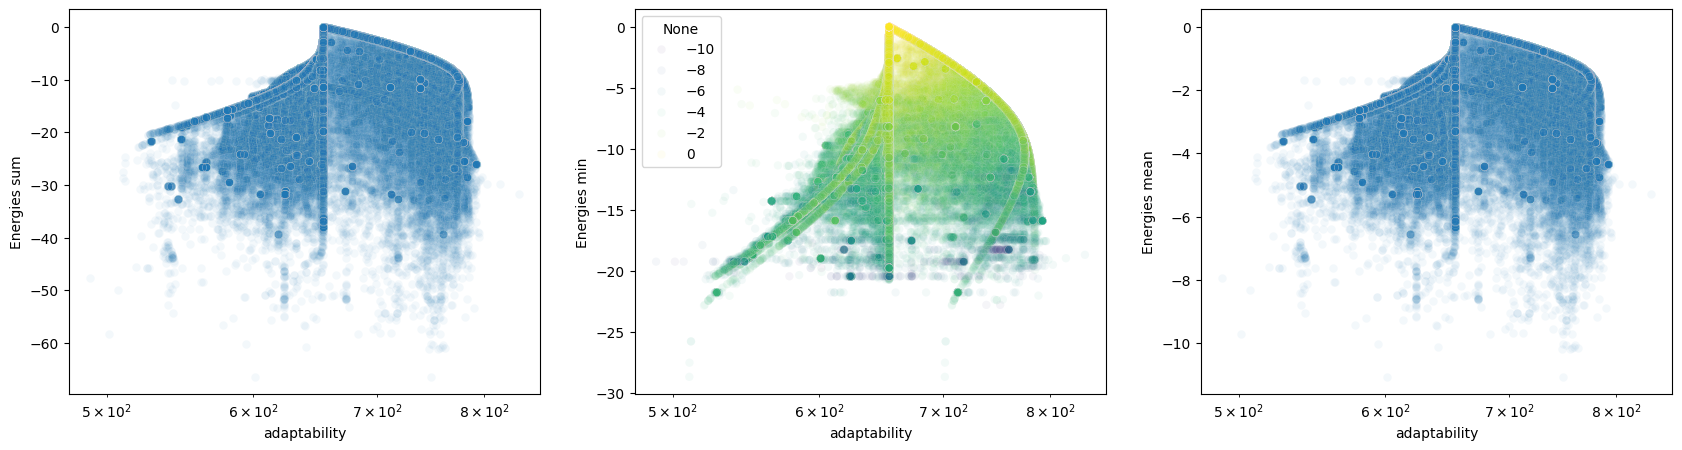

In [9]:
plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].sum(axis=1), alpha=0.05)
plt.xscale('log')
plt.ylabel('Energies sum')
ax = plt.subplot(1,4,2)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].min(axis=1), alpha=0.05,
                hue=df[X_COLS].mean(axis=1), palette='viridis')
plt.xscale('log')
plt.ylabel('Energies min')
ax = plt.subplot(1,4,3)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].mean(axis=1), alpha=0.05)
plt.xscale('log')
plt.ylabel('Energies mean')

### Reduce circuits that are overrepresented

In [10]:
df = df.reset_index(drop=True)

n_same_circ_max = 100
nbin = 300
agg_func = lambda x: np.sum(x, axis=1)
agg_func = lambda x: tuple(x)

df.loc[:, X_COLS] = df[X_COLS].apply(lambda x: np.round(x, 1))
df_bal = balance_dataset(df, cols=X_COLS, nbin=nbin, 
                         bin_max=n_same_circ_max, use_log=False, func1=agg_func)
df_bal = df_bal.reset_index(drop=True)


Text(0.5, 1.0, 'Adaptability after balancing')

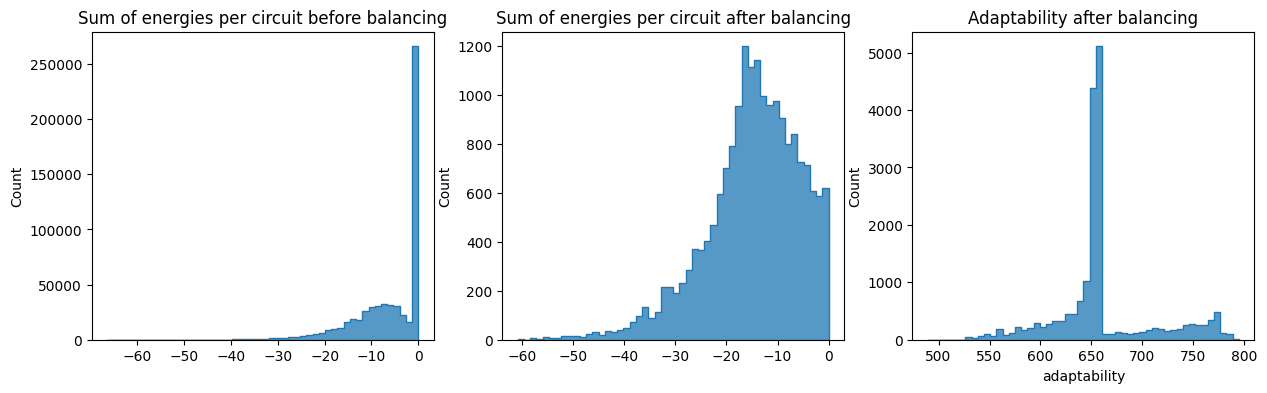

In [11]:
fig = plt.figure(figsize=(5*3, 4))
ax = plt.subplot(1,3,1)
sns.histplot(df[X_COLS].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit before balancing')
# ylim = ax.get_ylim()
ax = plt.subplot(1,3,2)
sns.histplot(df_bal[X_COLS].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit after balancing')
# plt.ylim(ylim)
ax = plt.subplot(1,3,3)
sns.histplot(df_bal, x='adaptability', bins=50, log_scale=[False, False], element='step')
plt.title('Adaptability after balancing')


Text(0.5, 0.98, 'Energies of species in a peak adaptability range')

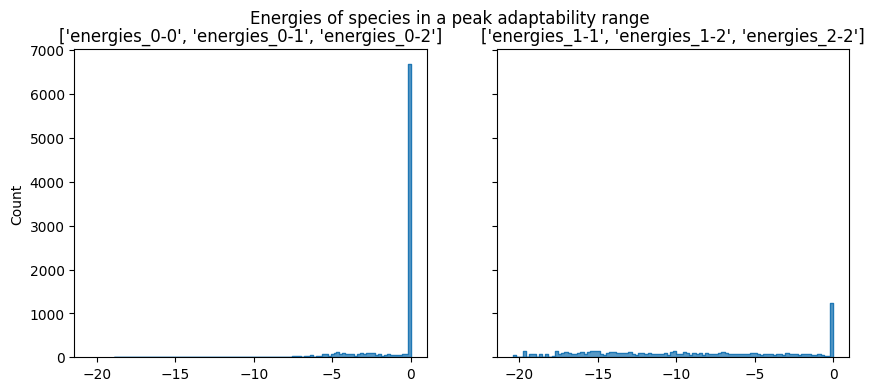

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

sns.histplot(df_bal[df_bal['adaptability'].between(650, 660)][X_COLS[:3]].min(axis=1), bins=100, element='step',
             ax=axs[0], log_scale=[False, False])
axs[0].set_title(X_COLS[:3])
sns.histplot(df_bal[df_bal['adaptability'].between(650, 660)][X_COLS[3:]].min(axis=1), bins=100, element='step',
             ax=axs[1], log_scale=[False, False])
axs[1].set_title(X_COLS[3:])
plt.suptitle('Energies of species in a peak adaptability range')

### Reduce the number of null circuits

In [13]:
# n_null_max = 100
# idxs_null = df[df[X_COLS].sum(axis=1) == 0].index

# df_bal2 = rem_idxs(df, np.random.choice(idxs_null, len(idxs_null) - n_null_max, replace=False))


# fig = plt.figure(figsize=(10,5))
# ax = plt.subplot(1,2,1)
# sns.histplot(df[X_COLS].sum(axis=1), bins=50, element='step')
# plt.title('Before')
# plt.xlabel('Sum of interactions')
# ax = plt.subplot(1,2,2)
# plt.title('After')
# plt.xlabel('Sum of interactions')
# sns.histplot(df_bal2[X_COLS].sum(axis=1), bins=50, element='step')
# plt.suptitle('Balancing null circuits')


In [14]:
# bin_max = int(np.power(10, 3))
# nbin = 50
# func1 = lambda x: np.sum(x, axis=1)
# # df_bal = balance_dataset2d(df_bal, cols1=X_COLS, cols2=OBJECTIVE_COL, nbins=nbin, bin_max=bin_max, use_log=False, func1=func1, func2=None)

# fig = plt.figure(figsize=(10,4))
# ax = plt.subplot(1,2,1)
# sns.histplot(x=df_bal[OBJECTIVE_COL].T, y=func1(df_bal[X_COLS].values).T, bins=nbin, cbar=True)
# plt.title('Before')

# # Need to recurse this subsampling to make it neat
# for i in range(20):
#     df_bal = balance_dataset2d(df_bal, cols1=X_COLS, cols2=OBJECTIVE_COL, nbins=nbin, bin_max=bin_max, use_log=False, func1=func1, func2=None)

# ax = plt.subplot(1,2,2)
# plt.title('After')
# sns.histplot(x=df_bal[OBJECTIVE_COL].T, y=func1(df_bal[X_COLS].values).T, bins=nbin, cbar=True)
# plt.suptitle('Balancing energies + adaptability')

Text(0.5, 0.98, 'Balance of dataset for conditioning variable adaptability')

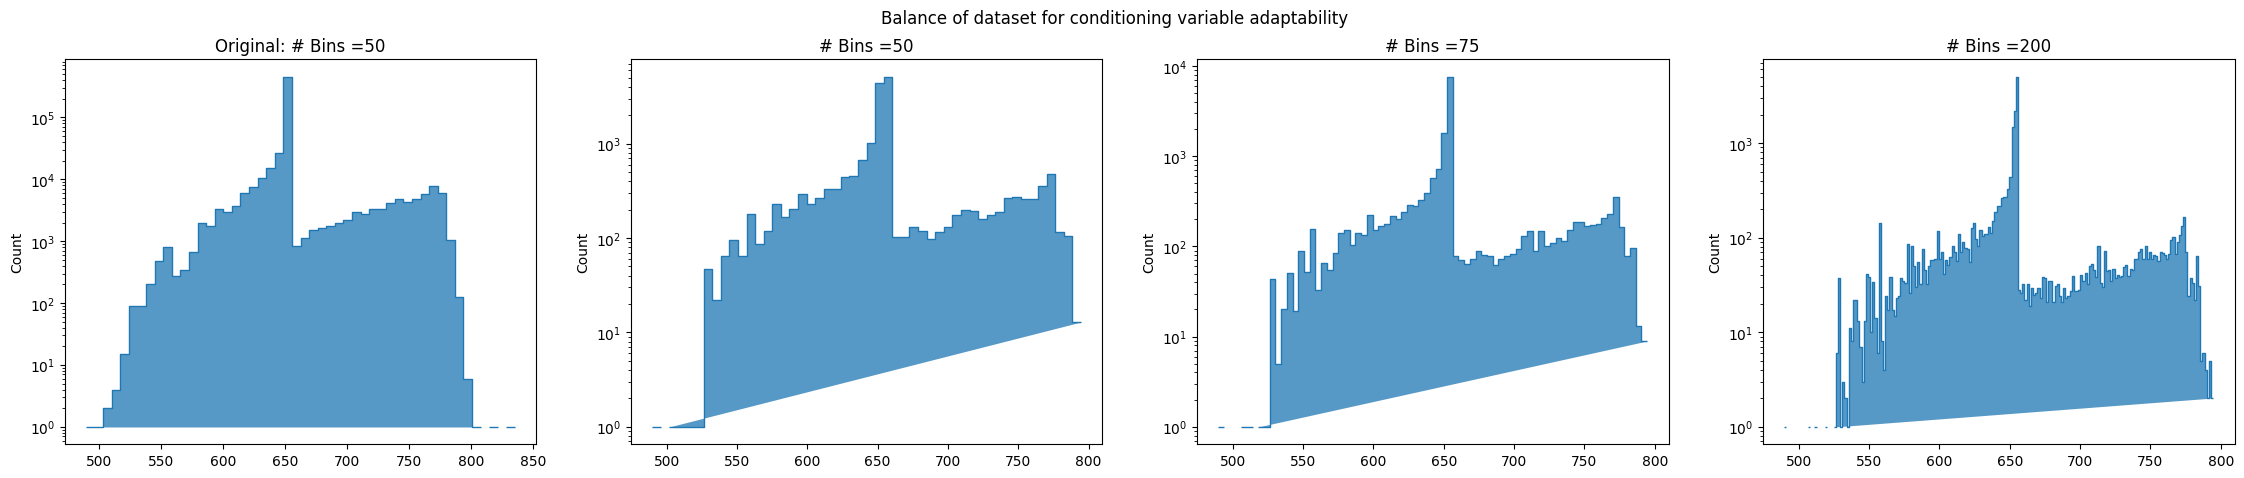

In [15]:
# Balance by bins
nbin = 50
bin_max = int(np.power(10, 4))
# df_bal = balance_dataset(df_bal, cols=OBJECTIVE_COL, nbin=nbin, bin_max=bin_max, use_log=False)
# df_bal = balance_dataset(df, cols=X_COLS, nbin=300, bin_max=bin_max, use_log=False, func1=lambda x: np.sum(x, axis=1))

fig = plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.histplot(df[OBJECTIVE_COL].to_numpy().flatten(), bins=50, log_scale=[False, True], element='step')
plt.title('Original: # Bins =' + str(50))
ax = plt.subplot(1,4,2)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=nbin, log_scale=[False, True], element='step')
plt.title('# Bins =' + str(nbin))
ax = plt.subplot(1,4,3)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=int(nbin*1.5), log_scale=[False, True], element='step')
plt.title('# Bins =' + str(int(nbin*1.5)))
ax = plt.subplot(1,4,4)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=nbin*4, log_scale=[False, True], element='step')
plt.title('# Bins =' + str(nbin*4))

plt.suptitle('Balance of dataset for conditioning variable ' + str(OBJECTIVE_COL))


In [16]:
TOTAL_DS = int(np.min([TOTAL_DS, TOTAL_DS_MAX, len(df_bal)]))
TOTAL_DS = int(TOTAL_DS // BATCH_SIZE * BATCH_SIZE)
N_BATCHES = int(TOTAL_DS // BATCH_SIZE)

x = [df_bal[i].iloc[:TOTAL_DS].values[:, None] for i in X_COLS]
x = np.concatenate(x, axis=1).squeeze()
x.shape

(18688, 6)

### Scale the input data

In [17]:
x_scaling, x_unscaling = [], []
if USE_NEG_ENERGY:
    x_scaling.append(lambda x: -x)
    x_unscaling.append(lambda x: -x)

if USE_X_LOGSCALE:
    x_scaling.append(np.log10)
    x_unscaling.append(lambda x: np.power(10, x))

if SCALE_X_MINMAX:
    xscaler = MinMaxScaler()
    x_scaling.append(xscaler.fit_transform)
    x_unscaling.append(xscaler.inverse_transform)

x_unscaling = x_unscaling[::-1]

for fn in x_scaling:
    x = fn(x)

### Conditioning variable: target function

In [18]:
cond = df_bal[OBJECTIVE_COL].iloc[:TOTAL_DS].to_numpy()

y_scaling, y_unscaling = [], []

if USE_CATEGORICAL:

    vectorized_convert_to_scientific_exponent = np.vectorize(
        convert_to_scientific_exponent)
    numerical_resolution = 2
    cond_map = {k: numerical_resolution for k in np.arange(int(f'{cond[cond != 0].min():.0e}'.split(
        'e')[1])-1, np.max([int(f'{cond.max():.0e}'.split('e')[1])+1, 0 + 1]))}
    cond_map[-6] = 1
    cond_map[-5] = 1
    cond_map[-4] = 4
    cond_map[-3] = 2
    cond_map[-1] = 3
    cond = jax.tree_util.tree_map(partial(
        vectorized_convert_to_scientific_exponent, numerical_resolution=cond_map), cond)
    cond = np.interp(cond, sorted(np.unique(cond)), np.arange(
        len(sorted(np.unique(cond))))).astype(int)

if USE_Y_LOGSCALE:
    zero_log_replacement = -10.0
    cond = np.where(cond != 0, np.log10(cond), zero_log_replacement)
    y_scaling.append(lambda x: np.where(x != 0, np.log10(x), zero_log_replacement))
    y_unscaling.append(lambda x: np.where(x != zero_log_replacement, np.power(10, x), 0))
    
if SCALE_Y_MINMAX:
    yscaler = MinMaxScaler()
    cond = yscaler.fit_transform(cond[:, None])
    cond = cond.squeeze()
    y_scaling.append(yscaler.transform)
    y_unscaling.append(yscaler.inverse_transform)

cond = cond[:, None]
N_HEAD = x.shape[-1]

x, cond = shuffle(x, cond, random_state=SEED)

if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

In [19]:
np.concatenate([x, cond], axis=1).shape

(18688, 7)

Text(0.5, 0.98, 'Dataset after balancing')

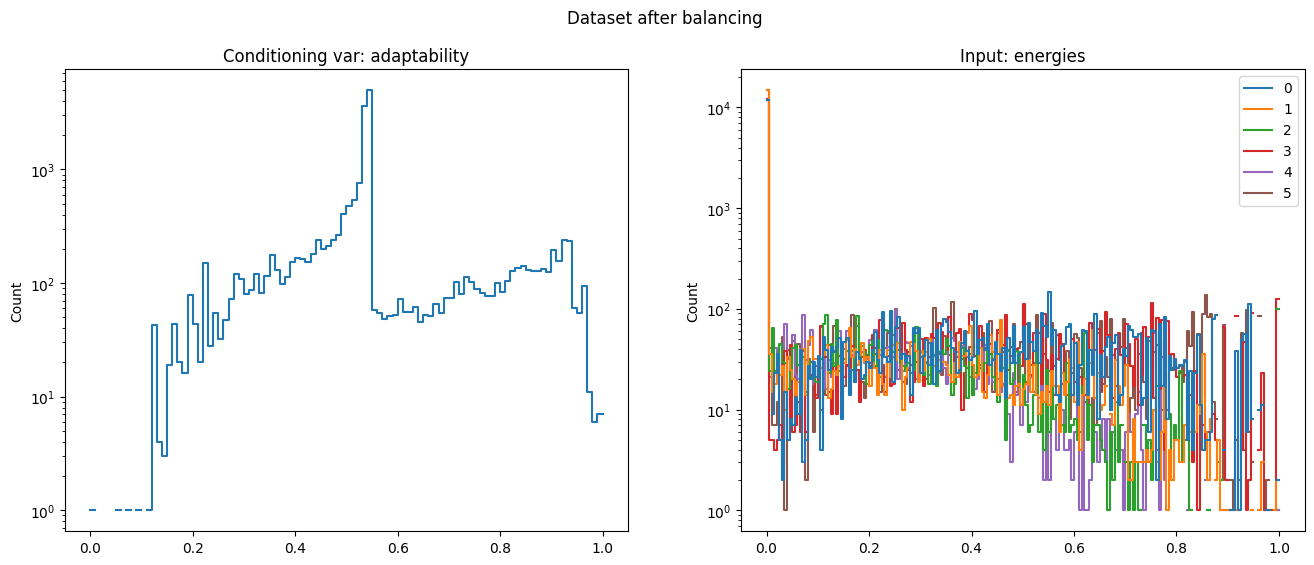

In [20]:
fig = plt.figure(figsize=(2*8, 6))

ax = plt.subplot(1,2,1)
sns.histplot(cond.flatten(), log_scale=[False, True], bins=100, element='step', fill=False)
plt.title(f'Conditioning var: {OBJECTIVE_COL}')

ax = plt.subplot(1,2,2)
sns.histplot(x, element='step', fill=False, bins=200, log_scale=[False, True])
plt.title(f'Input: {X_TYPE}')

plt.suptitle('Dataset after balancing')

## Init model

In [21]:
def VAE_fn(enc_layers: list, dec_layers: list, call_kwargs: dict = {}):
    encoder = MLP(layer_sizes=enc_layers, n_head=dec_layers[0], use_categorical=False, name='encoder')
    decoder = MLP(layer_sizes=dec_layers, n_head=x.shape[-1], use_categorical=False, name='decoder')
    model = CVAE(encoder=encoder, decoder=decoder, embed_size=HIDDEN_SIZE)
    
    def init(x: np.ndarray, cond: np.ndarray, deterministic: bool):
        h = model.encoder(np.concatenate([x, cond], axis=-1))

        mu = model.h2mu(h)
        logvar = model.h2logvar(h)
        z = model.reparameterize(mu, logvar, hk.next_rng_key(), deterministic)
        z_cond = np.concatenate([z, cond], axis=-1)

        y = model.decoder(z_cond)
        return y
        
    return init, (encoder, decoder, model) #model(x, **call_kwargs)

model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers)
# model = hk.transform(model_fn)
model_t = hk.multi_transform(model_fn)
params = model_t.init(PRNG, x, cond, deterministic=False)


/usr/local/lib/python3.11/dist-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/usr/local/lib/python3.11/dist-packages/haiku/_src/base.py:661: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


/usr/local/lib/python3.11/dist-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/usr/local/lib/python3.11/dist-packages/haiku/_src/base.py:661: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [22]:
encoder, decoder, model = model_t.apply

In [23]:
h = encoder(params, PRNG, np.concatenate([x, cond], axis=-1))

In [24]:
model(params, PRNG, x, cond)

Array([[ 0.7201188 ,  0.30684078,  0.08880839,  0.19907813,  0.80231965,
         0.66568077],
       [ 0.8565905 ,  0.5321708 ,  0.08917463,  0.3412172 ,  0.89697754,
         0.7771346 ],
       [ 1.1350592 ,  0.67204344, -0.15485814,  0.49001318,  1.121745  ,
         0.78611386],
       ...,
       [ 0.88020265,  0.39736176,  0.01497463,  0.33491772,  0.97035563,
         0.641531  ],
       [ 1.389114  ,  0.72099483, -0.03507329,  0.26239157,  1.1241208 ,
         0.83960545],
       [ 1.1673788 ,  0.6407299 ,  0.0299256 ,  0.2437571 ,  1.0659884 ,
         0.75363296]], dtype=float32)

## Init optimiser

In [25]:
optimiser = make_optimiser(LEARNING_RATE_SCHED, LEARNING_RATE,
                           EPOCHS, L2_REG_ALPHA, USE_WARMUP, WARMUP_EPOCHS, N_BATCHES)
optimiser_state = optimiser.init(x)

# Train

In [26]:
x = x.reshape(N_BATCHES, BATCH_SIZE, x.shape[-1])
cond = cond.reshape(N_BATCHES, BATCH_SIZE, cond.shape[-1])
y = x.reshape(N_BATCHES, BATCH_SIZE, x.shape[-1])

x_train, cond_train, y_train = x[:int(TRAIN_SPLIT * N_BATCHES)], cond[:int(TRAIN_SPLIT * N_BATCHES)], y[:int(TRAIN_SPLIT * N_BATCHES)]
x_val, cond_val, y_val = x[int(TRAIN_SPLIT * N_BATCHES):], cond[int(TRAIN_SPLIT * N_BATCHES):], y[int(TRAIN_SPLIT * N_BATCHES):]

x_train.shape

(116, 128, 6)

In [27]:
np.prod(x_train.shape[:2]), np.prod(x_val.shape[:2])


(np.int64(14848), np.int64(3840))

In [28]:
def train_step(params, x, y, cond, optimiser_state, model, rng, use_l2_reg, l2_reg_alpha, optimiser, loss_fn):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, cond=cond)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, optimiser_state, loss, grads


def eval_step(params, rng, model, x, y, cond, use_l2_reg, l2_reg_alpha, loss_fn, compute_accuracy):
    """ Return the average of loss and accuracy on validation data """
    loss = loss_fn(params, rng, model, x, y, use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, cond=cond)
    pred_y = model(params, rng, x, cond=cond)
    acc = compute_accuracy(pred_y, y)
    return acc, loss


def run_batches(params, model, rng,
                x_batch, y_batch, cond_batch,
                use_l2_reg, l2_reg_alpha, optimiser, optimiser_state, loss_fn):

    f_train_step = partial(train_step, model=model, rng=rng,
                           use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, optimiser=optimiser,
                           loss_fn=loss_fn)

    def f(carry, inp):

        params, optimiser_state = carry[0], carry[1]
        x_batch, y_batch, cond_batch = inp[0], inp[1], inp[2]

        params, optimiser_state, loss, grads = f_train_step(
            params, x_batch, y_batch, cond_batch, optimiser_state)
        return (params, optimiser_state), (loss, grads)

    # for x_batch, y_batch in xy_train:
    (params, optimiser_state), (train_loss, grads) = jax.lax.scan(
        f, (params, optimiser_state), (x_batch, y_batch, cond_batch))
    return params, optimiser_state, train_loss, grads


def train(params, rng, model,
          x_train, cond_train, y_train, x_val, cond_val, y_val,
          optimiser, optimiser_state,
          use_l2_reg, l2_reg_alpha, epochs,
          loss_fn, compute_accuracy,
          save_every, include_params_in_saves):

    def f(carry, _):
        params, optimiser_state = carry[0], carry[1]

        params, optimiser_state, train_loss, grads = run_batches(
            params, model, rng, x_train, y_train, cond_train, use_l2_reg, l2_reg_alpha, optimiser, optimiser_state, loss_fn)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, cond_val, use_l2_reg, l2_reg_alpha, loss_fn, compute_accuracy)

        return (params, optimiser_state), (params, grads, train_loss, val_loss, val_acc)

    saves = {}
    for e in range(epochs):
        (params, optimiser_state), (params_stack, grads, train_loss,
                                    val_loss, val_acc) = f((params, optimiser_state), None)

        if np.mod(e, save_every) == 0:
            saves[e] = make_saves(
                train_loss, val_loss, val_acc, include_params_in_saves, params_stack, grads)
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {np.mean(train_loss)}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')

    saves[list(saves.keys())[-1]]['params'] = params
    return params, saves

In [29]:
tstart = datetime.now()
params, saves = train(params, PRNG, model, 
                      x_train, cond_train, y_train, x_val, cond_val, y_val, 
                      optimiser, optimiser_state,
                      use_l2_reg=USE_L2_REG, l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS,
                      loss_fn=loss_fn, compute_accuracy=accuracy_regression,
                      save_every=PRINT_EVERY, include_params_in_saves=False) 

print(datetime.now() - tstart)

Epoch 0 / 1000 -		 Train loss: 0.36013662815093994	Val loss: 0.2682545483112335	Val accuracy: 0.13159722089767456


Epoch 10 / 1000 -		 Train loss: 0.0632425919175148	Val loss: 0.06487521529197693	Val accuracy: 0.33884549140930176


Epoch 20 / 1000 -		 Train loss: 0.058148302137851715	Val loss: 0.060356948524713516	Val accuracy: 0.3547743260860443


Epoch 30 / 1000 -		 Train loss: 0.05532132089138031	Val loss: 0.057569876313209534	Val accuracy: 0.3680121600627899


Epoch 40 / 1000 -		 Train loss: 0.05386095494031906	Val loss: 0.056016456335783005	Val accuracy: 0.37378472089767456


Epoch 50 / 1000 -		 Train loss: 0.0529598742723465	Val loss: 0.05505088344216347	Val accuracy: 0.3793836832046509


Epoch 60 / 1000 -		 Train loss: 0.05233604460954666	Val loss: 0.054397180676460266	Val accuracy: 0.3832031488418579


Epoch 70 / 1000 -		 Train loss: 0.05184808373451233	Val loss: 0.053914234042167664	Val accuracy: 0.38641494512557983


Epoch 80 / 1000 -		 Train loss: 0.05142427235841751	Val loss: 0.05352666601538658	Val accuracy: 0.3899739682674408


Epoch 90 / 1000 -		 Train loss: 0.05102331191301346	Val loss: 0.05318024381995201	Val accuracy: 0.3943576514720917


Epoch 100 / 1000 -		 Train loss: 0.05061184987425804	Val loss: 0.05285589024424553	Val accuracy: 0.40004339814186096


Epoch 110 / 1000 -		 Train loss: 0.05015992373228073	Val loss: 0.052516572177410126	Val accuracy: 0.40572917461395264


Epoch 120 / 1000 -		 Train loss: 0.049626391381025314	Val loss: 0.05213331803679466	Val accuracy: 0.4112413227558136


Epoch 130 / 1000 -		 Train loss: 0.04895779490470886	Val loss: 0.051668211817741394	Val accuracy: 0.41714411973953247


Epoch 140 / 1000 -		 Train loss: 0.048088401556015015	Val loss: 0.051055677235126495	Val accuracy: 0.42526042461395264


Epoch 150 / 1000 -		 Train loss: 0.04693610966205597	Val loss: 0.05026520788669586	Val accuracy: 0.4366319477558136


Epoch 160 / 1000 -		 Train loss: 0.045344918966293335	Val loss: 0.049119748175144196	Val accuracy: 0.44691842794418335


Epoch 170 / 1000 -		 Train loss: 0.043126195669174194	Val loss: 0.04736906290054321	Val accuracy: 0.46167534589767456


Epoch 180 / 1000 -		 Train loss: 0.04016853868961334	Val loss: 0.044824570417404175	Val accuracy: 0.47929689288139343


Epoch 190 / 1000 -		 Train loss: 0.036765534430742264	Val loss: 0.04160471260547638	Val accuracy: 0.4956163167953491


Epoch 200 / 1000 -		 Train loss: 0.03349737823009491	Val loss: 0.038089998066425323	Val accuracy: 0.5146701335906982


Epoch 210 / 1000 -		 Train loss: 0.03072315827012062	Val loss: 0.034783538430929184	Val accuracy: 0.5322048664093018


Epoch 220 / 1000 -		 Train loss: 0.02860516868531704	Val loss: 0.03205487132072449	Val accuracy: 0.5503472089767456


Epoch 230 / 1000 -		 Train loss: 0.027072802186012268	Val loss: 0.02995886094868183	Val accuracy: 0.5690104365348816


Epoch 240 / 1000 -		 Train loss: 0.025902744382619858	Val loss: 0.028322940692305565	Val accuracy: 0.5844618082046509


Epoch 250 / 1000 -		 Train loss: 0.024927858263254166	Val loss: 0.026980377733707428	Val accuracy: 0.6001736521720886


Epoch 260 / 1000 -		 Train loss: 0.024021632969379425	Val loss: 0.025762004777789116	Val accuracy: 0.614062488079071


Epoch 270 / 1000 -		 Train loss: 0.023101622238755226	Val loss: 0.024557169526815414	Val accuracy: 0.6269097328186035


Epoch 280 / 1000 -		 Train loss: 0.022187327966094017	Val loss: 0.02336115948855877	Val accuracy: 0.6421006917953491


Epoch 290 / 1000 -		 Train loss: 0.021260704845190048	Val loss: 0.022164877504110336	Val accuracy: 0.6588541865348816


Epoch 300 / 1000 -		 Train loss: 0.020384907722473145	Val loss: 0.021051498129963875	Val accuracy: 0.6776909828186035


Epoch 310 / 1000 -		 Train loss: 0.019575772807002068	Val loss: 0.020027989521622658	Val accuracy: 0.694140613079071


Epoch 320 / 1000 -		 Train loss: 0.018843183293938637	Val loss: 0.01912720501422882	Val accuracy: 0.7115885615348816


Epoch 330 / 1000 -		 Train loss: 0.018172381445765495	Val loss: 0.018327908590435982	Val accuracy: 0.7259548902511597


Epoch 340 / 1000 -		 Train loss: 0.017545420676469803	Val loss: 0.01761382445693016	Val accuracy: 0.7364149689674377


Epoch 350 / 1000 -		 Train loss: 0.0169575996696949	Val loss: 0.016952957957983017	Val accuracy: 0.7457899451255798


Epoch 360 / 1000 -		 Train loss: 0.01638706773519516	Val loss: 0.016324639320373535	Val accuracy: 0.7551215291023254


Epoch 370 / 1000 -		 Train loss: 0.01581934466958046	Val loss: 0.01572386734187603	Val accuracy: 0.7631944417953491


Epoch 380 / 1000 -		 Train loss: 0.01524223294109106	Val loss: 0.015133962966501713	Val accuracy: 0.771397590637207


Epoch 390 / 1000 -		 Train loss: 0.014655344188213348	Val loss: 0.014546195976436138	Val accuracy: 0.7784722447395325


Epoch 400 / 1000 -		 Train loss: 0.014059699140489101	Val loss: 0.013962731696665287	Val accuracy: 0.7834201455116272


Epoch 410 / 1000 -		 Train loss: 0.013466189615428448	Val loss: 0.013380355201661587	Val accuracy: 0.7898871898651123


Epoch 420 / 1000 -		 Train loss: 0.012850948609411716	Val loss: 0.012780155055224895	Val accuracy: 0.7951822876930237


Epoch 430 / 1000 -		 Train loss: 0.012254190631210804	Val loss: 0.012208178639411926	Val accuracy: 0.8011285066604614


Epoch 440 / 1000 -		 Train loss: 0.01169201172888279	Val loss: 0.011662965640425682	Val accuracy: 0.8064670562744141


Epoch 450 / 1000 -		 Train loss: 0.01117412094026804	Val loss: 0.011152239516377449	Val accuracy: 0.8120225667953491


Epoch 460 / 1000 -		 Train loss: 0.010693118907511234	Val loss: 0.01067456603050232	Val accuracy: 0.8177083730697632


Epoch 470 / 1000 -		 Train loss: 0.010261529125273228	Val loss: 0.010247744619846344	Val accuracy: 0.8238281607627869


Epoch 480 / 1000 -		 Train loss: 0.009890089742839336	Val loss: 0.009878348559141159	Val accuracy: 0.8303385376930237


Epoch 490 / 1000 -		 Train loss: 0.009563402272760868	Val loss: 0.009553479962050915	Val accuracy: 0.8358073234558105


Epoch 500 / 1000 -		 Train loss: 0.00926898792386055	Val loss: 0.009259989485144615	Val accuracy: 0.8414062857627869


Epoch 510 / 1000 -		 Train loss: 0.009002305567264557	Val loss: 0.008993586525321007	Val accuracy: 0.8481770753860474


Epoch 520 / 1000 -		 Train loss: 0.008758633397519588	Val loss: 0.008751215413212776	Val accuracy: 0.853515625


Epoch 530 / 1000 -		 Train loss: 0.008535013534128666	Val loss: 0.008527792058885098	Val accuracy: 0.8584201335906982


Epoch 540 / 1000 -		 Train loss: 0.008325817994773388	Val loss: 0.008317278698086739	Val accuracy: 0.8625434041023254


Epoch 550 / 1000 -		 Train loss: 0.008127166889607906	Val loss: 0.008118374273180962	Val accuracy: 0.8665798902511597


Epoch 560 / 1000 -		 Train loss: 0.007932971231639385	Val loss: 0.007923184894025326	Val accuracy: 0.8711372017860413


Epoch 570 / 1000 -		 Train loss: 0.007699935231357813	Val loss: 0.007678462658077478	Val accuracy: 0.8764756917953491


Epoch 580 / 1000 -		 Train loss: 0.00744788721203804	Val loss: 0.0074297841638326645	Val accuracy: 0.8803385496139526


Epoch 590 / 1000 -		 Train loss: 0.007242362946271896	Val loss: 0.007225402165204287	Val accuracy: 0.8835069537162781


Epoch 600 / 1000 -		 Train loss: 0.007047416642308235	Val loss: 0.007030519191175699	Val accuracy: 0.8863281607627869


Epoch 610 / 1000 -		 Train loss: 0.006856587249785662	Val loss: 0.006839761510491371	Val accuracy: 0.8893663287162781


Epoch 620 / 1000 -		 Train loss: 0.00666779326274991	Val loss: 0.006651419680565596	Val accuracy: 0.8920139074325562


Epoch 630 / 1000 -		 Train loss: 0.006479657720774412	Val loss: 0.00646334420889616	Val accuracy: 0.8948351144790649


Epoch 640 / 1000 -		 Train loss: 0.006292074453085661	Val loss: 0.006276349537074566	Val accuracy: 0.8977431058883667


Epoch 650 / 1000 -		 Train loss: 0.00610527815297246	Val loss: 0.00608984986320138	Val accuracy: 0.9005642533302307


Epoch 660 / 1000 -		 Train loss: 0.0059194318018853664	Val loss: 0.0059041185304522514	Val accuracy: 0.9034722447395325


Epoch 670 / 1000 -		 Train loss: 0.005733940750360489	Val loss: 0.005718212574720383	Val accuracy: 0.9066840410232544


Epoch 680 / 1000 -		 Train loss: 0.0055498480796813965	Val loss: 0.005533238872885704	Val accuracy: 0.9091579914093018


Epoch 690 / 1000 -		 Train loss: 0.005366942845284939	Val loss: 0.005350056104362011	Val accuracy: 0.9110243320465088


Epoch 700 / 1000 -		 Train loss: 0.005185693968087435	Val loss: 0.005168348550796509	Val accuracy: 0.9130642414093018


Epoch 710 / 1000 -		 Train loss: 0.005007554776966572	Val loss: 0.004989746958017349	Val accuracy: 0.9148871898651123


Epoch 720 / 1000 -		 Train loss: 0.004833569750189781	Val loss: 0.004815010819584131	Val accuracy: 0.9170138835906982


Epoch 730 / 1000 -		 Train loss: 0.004664653446525335	Val loss: 0.004644592758268118	Val accuracy: 0.9190104603767395


Epoch 740 / 1000 -		 Train loss: 0.004501586779952049	Val loss: 0.004480201750993729	Val accuracy: 0.9209201335906982


Epoch 750 / 1000 -		 Train loss: 0.004345511551946402	Val loss: 0.004322956781834364	Val accuracy: 0.9231337308883667


Epoch 760 / 1000 -		 Train loss: 0.004196615424007177	Val loss: 0.004173289984464645	Val accuracy: 0.9253038167953491


Epoch 770 / 1000 -		 Train loss: 0.004055071622133255	Val loss: 0.004030630923807621	Val accuracy: 0.9268229603767395


Epoch 780 / 1000 -		 Train loss: 0.0039212992414832115	Val loss: 0.003895048052072525	Val accuracy: 0.9291666746139526


Epoch 790 / 1000 -		 Train loss: 0.003795393044129014	Val loss: 0.003767854766920209	Val accuracy: 0.930859386920929


Epoch 800 / 1000 -		 Train loss: 0.0036777243949472904	Val loss: 0.0036489726044237614	Val accuracy: 0.9323784708976746


Epoch 810 / 1000 -		 Train loss: 0.0035683235619217157	Val loss: 0.0035385701339691877	Val accuracy: 0.9346354603767395


Epoch 820 / 1000 -		 Train loss: 0.0034669258166104555	Val loss: 0.003436462255194783	Val accuracy: 0.9363281726837158


Epoch 830 / 1000 -		 Train loss: 0.003373434767127037	Val loss: 0.003342612413689494	Val accuracy: 0.9380642771720886


Epoch 840 / 1000 -		 Train loss: 0.0032875125762075186	Val loss: 0.003256513737142086	Val accuracy: 0.9397135376930237


Epoch 850 / 1000 -		 Train loss: 0.0032088449224829674	Val loss: 0.003177648177370429	Val accuracy: 0.9415364861488342


Epoch 860 / 1000 -		 Train loss: 0.0031369898933917284	Val loss: 0.0031056080479174852	Val accuracy: 0.943359375


Epoch 870 / 1000 -		 Train loss: 0.003071440616622567	Val loss: 0.0030398727394640446	Val accuracy: 0.944444477558136


Epoch 880 / 1000 -		 Train loss: 0.0030116145499050617	Val loss: 0.0029802126809954643	Val accuracy: 0.9457899332046509


Epoch 890 / 1000 -		 Train loss: 0.0029569014441221952	Val loss: 0.0029258006252348423	Val accuracy: 0.9467014074325562


Epoch 900 / 1000 -		 Train loss: 0.00290700513869524	Val loss: 0.0028764852322638035	Val accuracy: 0.9473090767860413


Epoch 910 / 1000 -		 Train loss: 0.002861634362488985	Val loss: 0.002831733552739024	Val accuracy: 0.9480469226837158


Epoch 920 / 1000 -		 Train loss: 0.0028202226385474205	Val loss: 0.0027911164797842503	Val accuracy: 0.9488281607627869


Epoch 930 / 1000 -		 Train loss: 0.0027823830023407936	Val loss: 0.0027541390154510736	Val accuracy: 0.9497396349906921


Epoch 940 / 1000 -		 Train loss: 0.0027479955460876226	Val loss: 0.002720555989071727	Val accuracy: 0.9504340291023254


Epoch 950 / 1000 -		 Train loss: 0.00271658506244421	Val loss: 0.0026899068616330624	Val accuracy: 0.9510416984558105


Epoch 960 / 1000 -		 Train loss: 0.002687903353944421	Val loss: 0.002661930862814188	Val accuracy: 0.9516059160232544


Epoch 970 / 1000 -		 Train loss: 0.002661768114194274	Val loss: 0.002636478515341878	Val accuracy: 0.952256977558136


Epoch 980 / 1000 -		 Train loss: 0.0026379134505987167	Val loss: 0.0026133484207093716	Val accuracy: 0.9527778029441833


Epoch 990 / 1000 -		 Train loss: 0.002616200363263488	Val loss: 0.0025923296343535185	Val accuracy: 0.9534288644790649


0:11:32.972856


# Visualise

Text(0.5, 0, 'step')

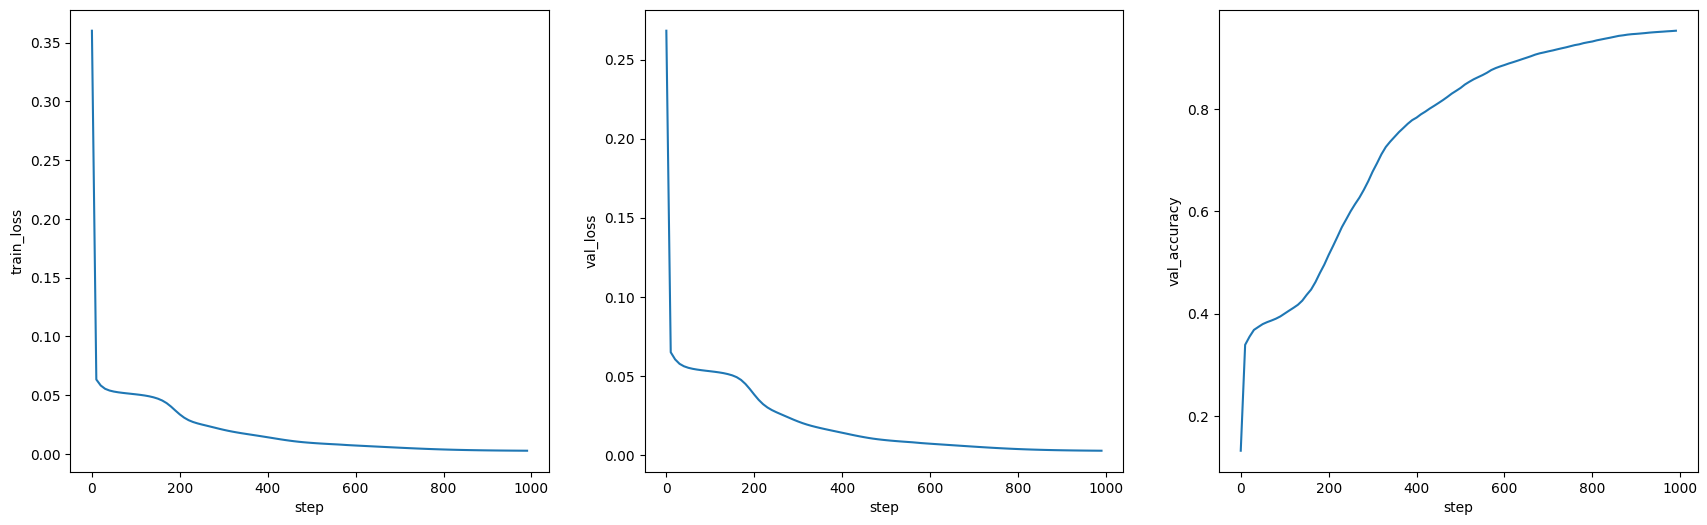

In [30]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

In [31]:
write_json(saves, out_path=save_path)

In [32]:
print(save_path)

weight_saves/01_cvae/2024_11_29__10_43_59_saves_test


# Examine trained model

In [33]:
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__15_01_35_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__16_58_36_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_28__14_12_59_saves_test')
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)
# p['vae/~/h2mu'] = p.pop('vae/~/linear')
# p['vae/~/h2logvar'] = p.pop('vae/~/linear_1')

pred_y = model(p, PRNG, x, cond)
pred_y.shape

(146, 128, 6)

Text(0.5, 0, 'step')

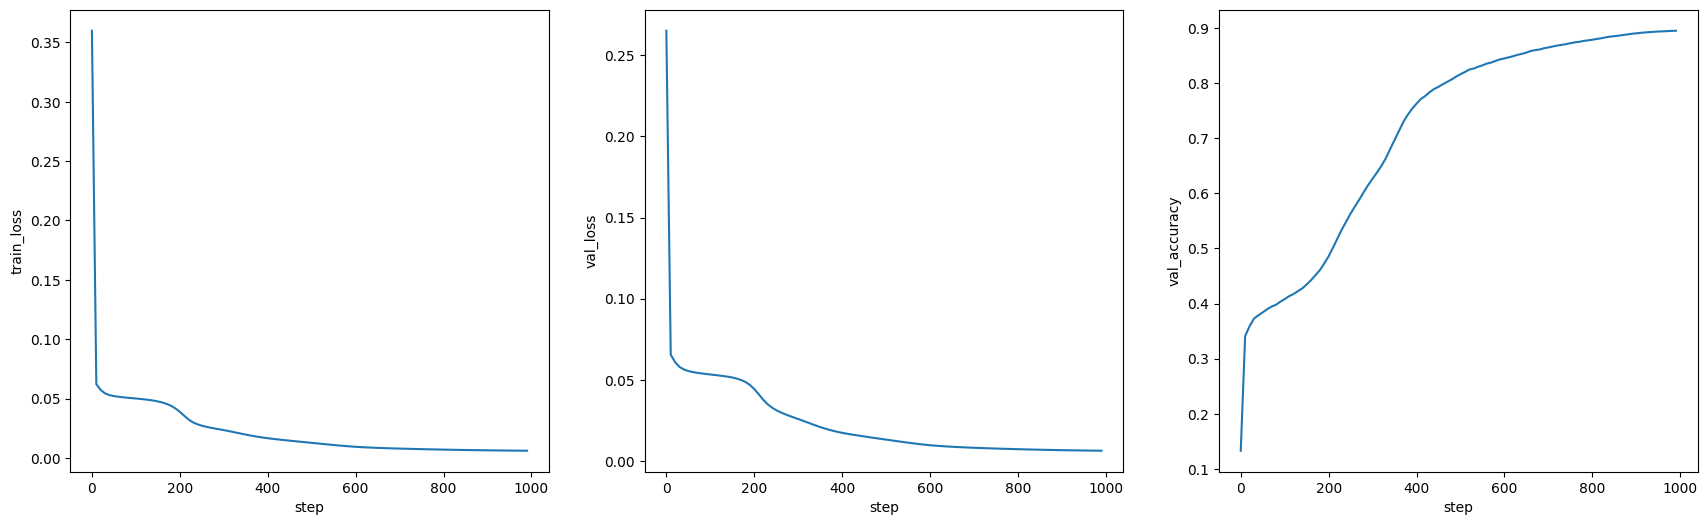

In [34]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['train_loss']) for v in saves_loaded.values()]))
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_loss']) for v in saves_loaded.values()]))
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_accuracy']) for v in saves_loaded.values()]))
plt.ylabel('val_accuracy')
plt.xlabel('step')

The R2 score is  0.877161675013488
The R2 score with weighted variance is  0.877161675013488


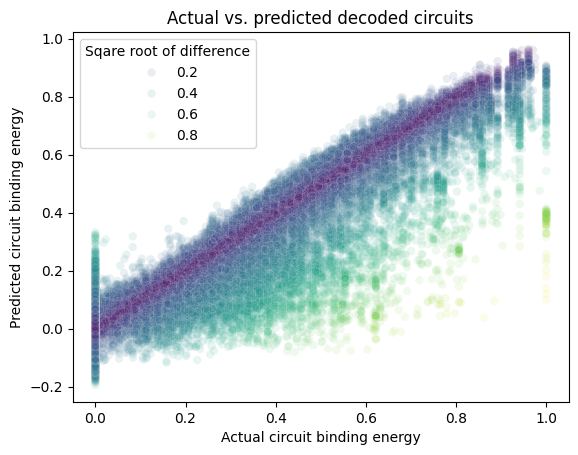

In [35]:
g = sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y.flatten() - y.flatten())), palette='viridis')
g.legend_.set_title('Sqare root of difference')
plt.title(f'Actual vs. predicted decoded circuits')
plt.xlabel('Actual circuit binding energy')
plt.ylabel('Predicted circuit binding energy')

print('The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
print('The R2 score with weighted variance is ', r2_score(
    y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

# Sample fake circuits

In [36]:
n_to_sample = 10000

sampled_cond = np.interp(np.random.rand(n_to_sample, cond.shape[-1]), [0, 1], [cond.min(), cond.max()])
mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 5000
logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 100
z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = decoder(p, PRNG, z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)
sampled_cond.shape

(10000, 1)

Text(0.5, 0.98, 'Interactions for CVAE: 10000 circuits')

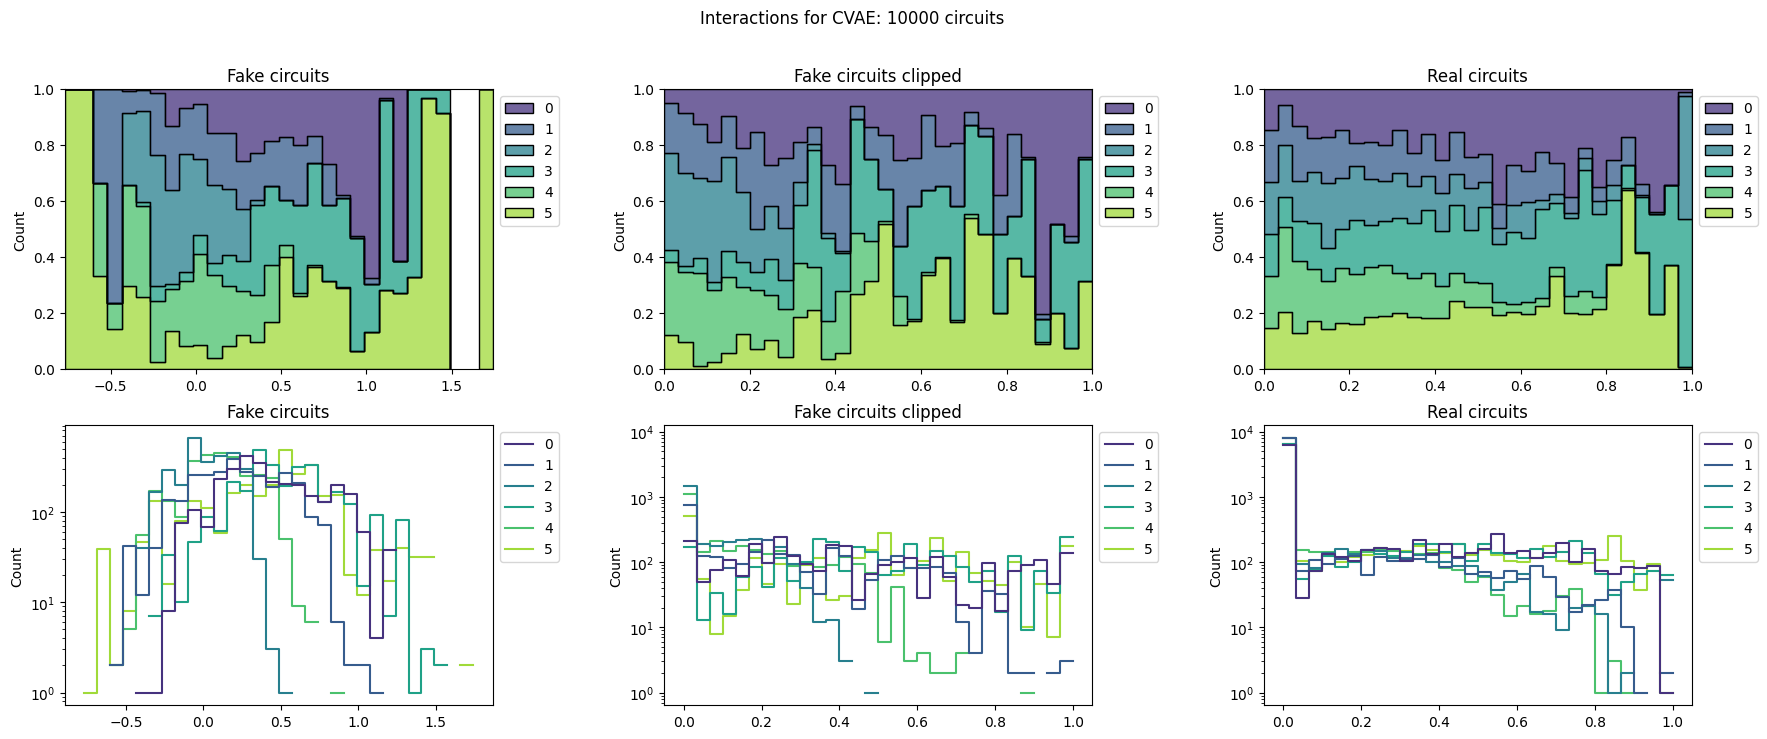

In [37]:
fig = plt.figure(figsize=(7*3, 8))
fig.subplots_adjust(wspace=0.4)

ax = plt.subplot(2, 3, 1)
g = sns.histplot(fake_circuits, element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 2)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 3)
g = sns.histplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample],
                 element='step', bins=30, palette='viridis', multiple='fill')
plt.title('Real circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 4)
g = sns.histplot(fake_circuits, element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 5)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 6)
x_hist = x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample]
g2 = sns.histplot(x_hist, element='step', bins=30, palette='viridis',
                  multiple='layer', fill=False, log_scale=[False, True])
plt.title('Real circuits')
sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))

g.set_ylim(g2.get_ylim())

plt.suptitle(f'Interactions for CVAE: {n_to_sample} circuits')

Text(0.5, 0.98, 'CVAE: 2000 circuits')

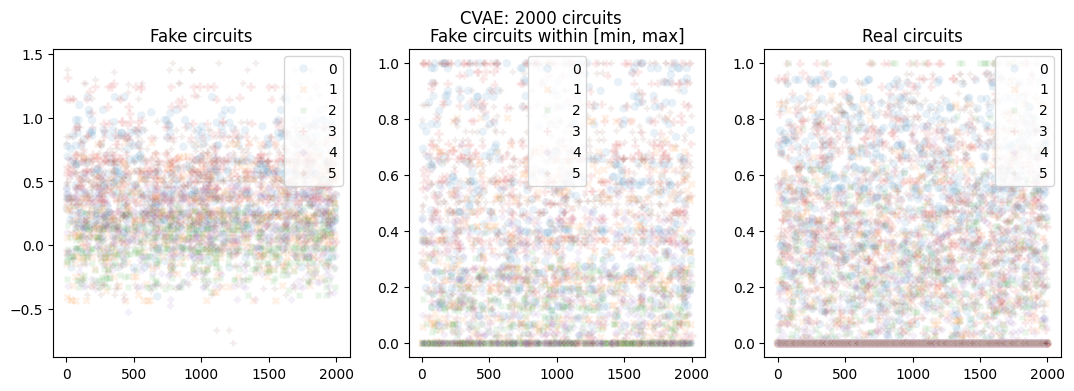

In [38]:
fig = plt.figure(figsize=(13, 4))

show_max = 2000

ax = plt.subplot(1, 3, 1)
sns.scatterplot(fake_circuits[:show_max], alpha=0.1)
plt.title('Fake circuits')

ax = plt.subplot(1, 3, 2)
fake_circuits_1 = np.where(fake_circuits[:show_max] > x.max(), x.max(), fake_circuits[:show_max])
sns.scatterplot(np.where(fake_circuits_1 < x.min(), x.min(), fake_circuits_1), alpha=0.1)
plt.title('Fake circuits within [min, max]')

ax = plt.subplot(1, 3, 3)
sns.scatterplot(
    x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:show_max], alpha=0.1)
plt.title('Real circuits')

plt.suptitle(f'CVAE: {show_max} circuits')

## Conditionality

In [39]:
n_categories = 5
n_to_sample = 10000

sampled_cond = np.repeat(np.linspace(cond.min(), cond.max(), n_categories)[:, None], repeats=n_to_sample, axis=1)[:, :, None]
mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 1
logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 2
z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = np.repeat(z[None, :], repeats=n_categories, axis=0)
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = jax.vmap(partial(decoder, params=p, rng=PRNG))(x=z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)

Text(0.5, 0.98, 'CVAE: fake circuits')

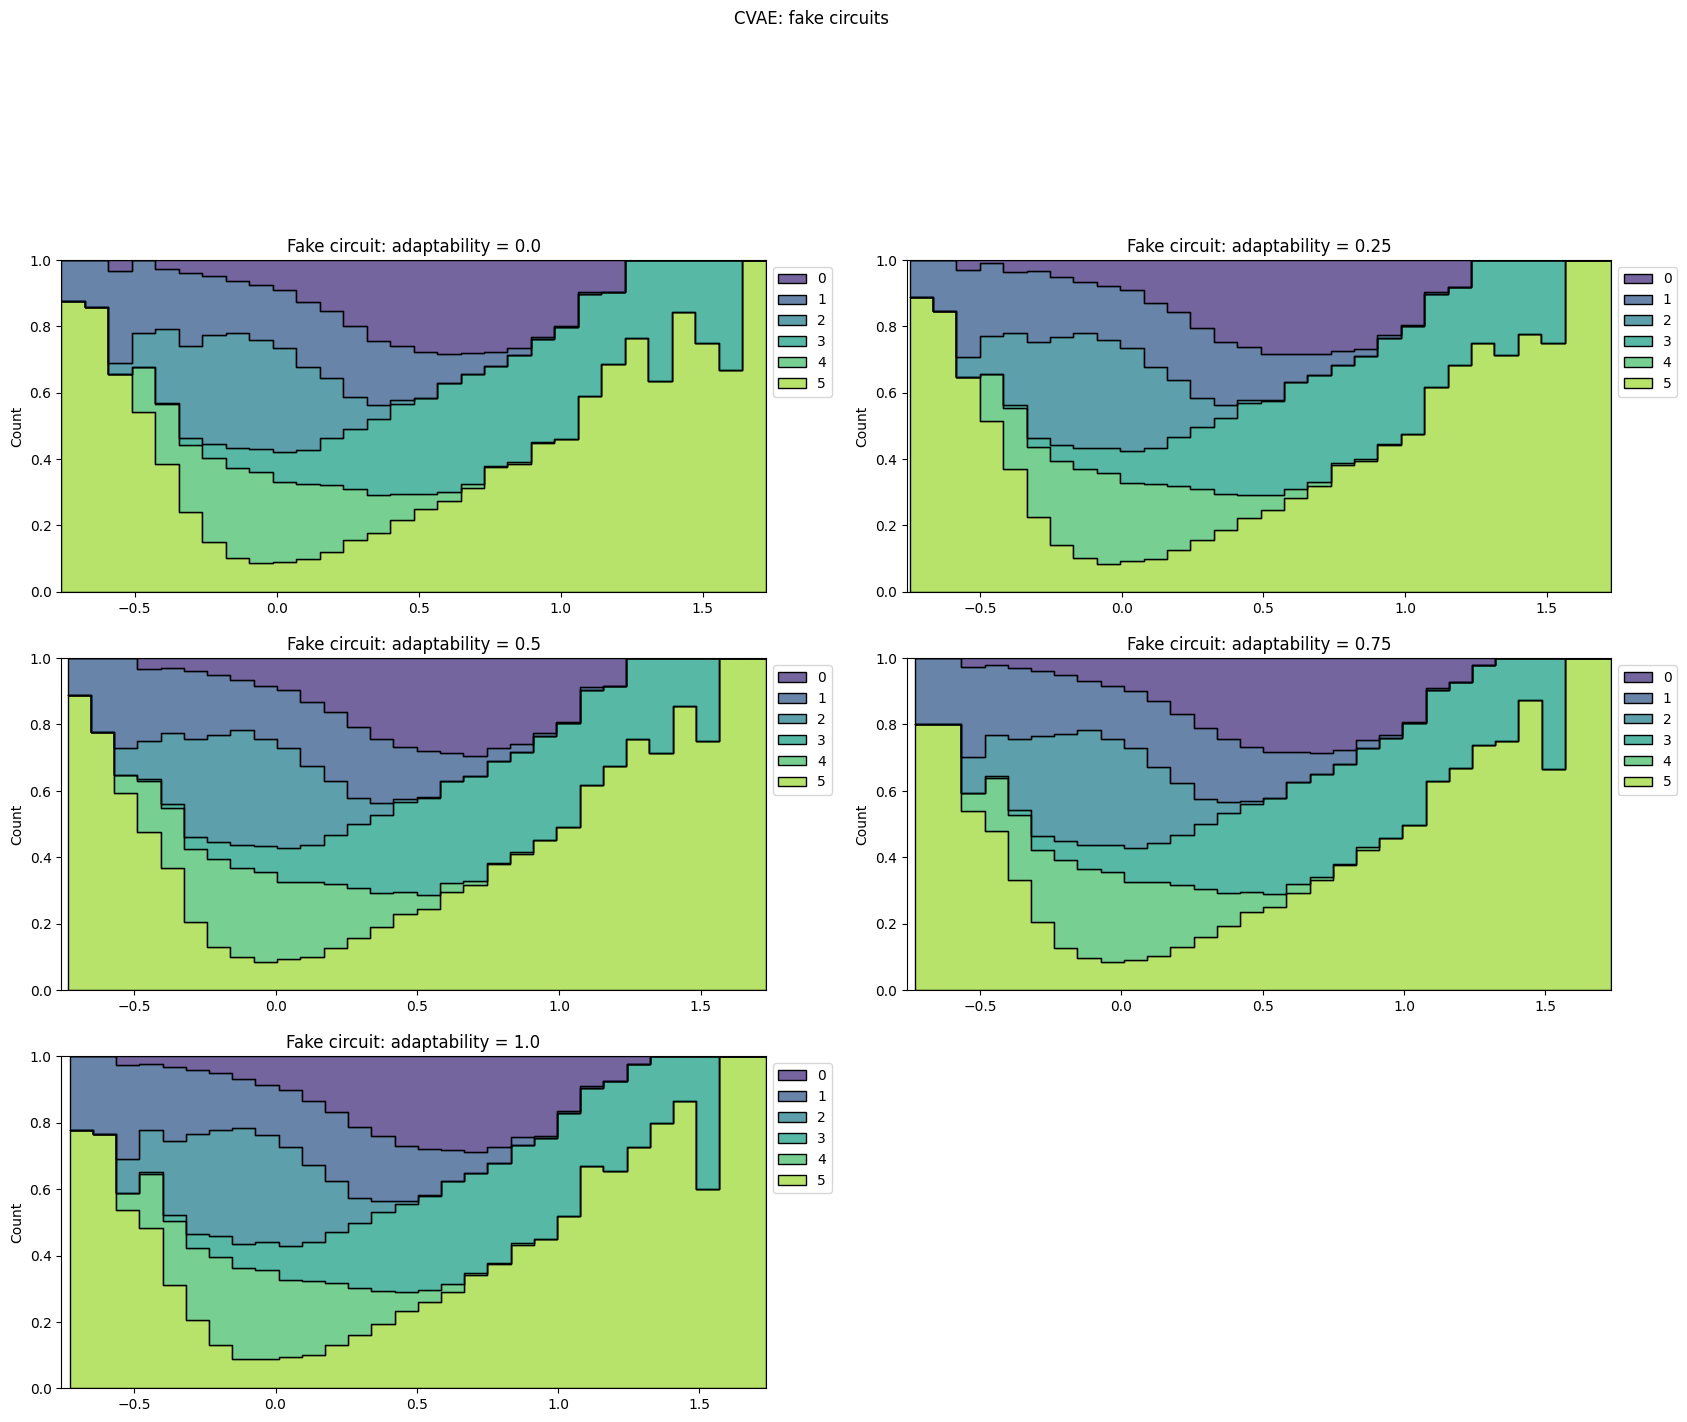

In [40]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
widest_lim = [0, 0]
for i, (zi, cat) in enumerate(zip(z, fake_circuits)):
    ax = plt.subplot(5, 2, i+1)
    # g = sns.scatterplot(cat[:show_max])
    g = sns.histplot(cat, element='step', bins=30, palette='viridis', multiple='fill')
    plt.title(f'Fake circuit: {OBJECTIVE_COL} = {str(sorted(np.unique(sampled_cond))[i])[:6]}')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
    widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
    g.set_xlim(widest_lim)

plt.suptitle(f'CVAE: fake circuits')

### Compare to real circuit's sensitivity

In [41]:
def round_to_nearest_array(x, y):
    """ 
    x: array to be mapped over
    y: array with integers to round to """
    distances = np.abs(x[:, None] - y[None, :])
    nearest_indices = np.argmin(distances, axis=1)
    nearest_values = y[nearest_indices]
    return nearest_values


def bin_to_nearest_edge(x: np.ndarray, n_bins):
    """ Bin the elements in x to the nearest lowest bin """
    edges = np.linspace(x.min(), x.max(), n_bins)
    return round_to_nearest_array(x, edges)


def apply_fns(x, fns: list):
    og_shape = x.shape
    if x.ndim > 2:
        x = x.reshape(*(np.prod(x.shape[:-1]), x.shape[-1]))
    for fcn in fns:
        x = fcn(x)
    return x.reshape(og_shape)

df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(np.log10(df[OBJECTIVE_COL].to_numpy()), n_bins=n_categories)
fake_circuits = apply_fns(fake_circuits, fns = x_unscaling)


In [42]:
fake_circuits = np.where(fake_circuits > df[X_COLS[0]].max().max(), df[X_COLS[0]].max().max(), fake_circuits)

In [43]:
cat

Array([[ 0.08263878,  0.17503938,  0.10502601,  0.49252748, -0.0182286 ,
         0.08824603],
       [ 0.7482132 , -0.05285753,  0.01297408,  0.80268466,  0.3335297 ,
         0.04075142],
       [ 0.29920897,  0.15903018,  0.205366  ,  0.44763967,  0.05738844,
         0.19650438],
       ...,
       [ 0.2438013 ,  0.10000358,  0.13870887,  0.54063827,  0.05974039,
        -0.11679085],
       [ 0.38683337,  0.24831994, -0.01416649,  0.28585213,  0.2150142 ,
        -0.01018206],
       [ 0.09381676,  0.00587558,  0.07928549, -0.10552983,  0.4109431 ,
         0.2903449 ]], dtype=float32)

Text(0.5, 0.98, 'CVAE: real circuits')

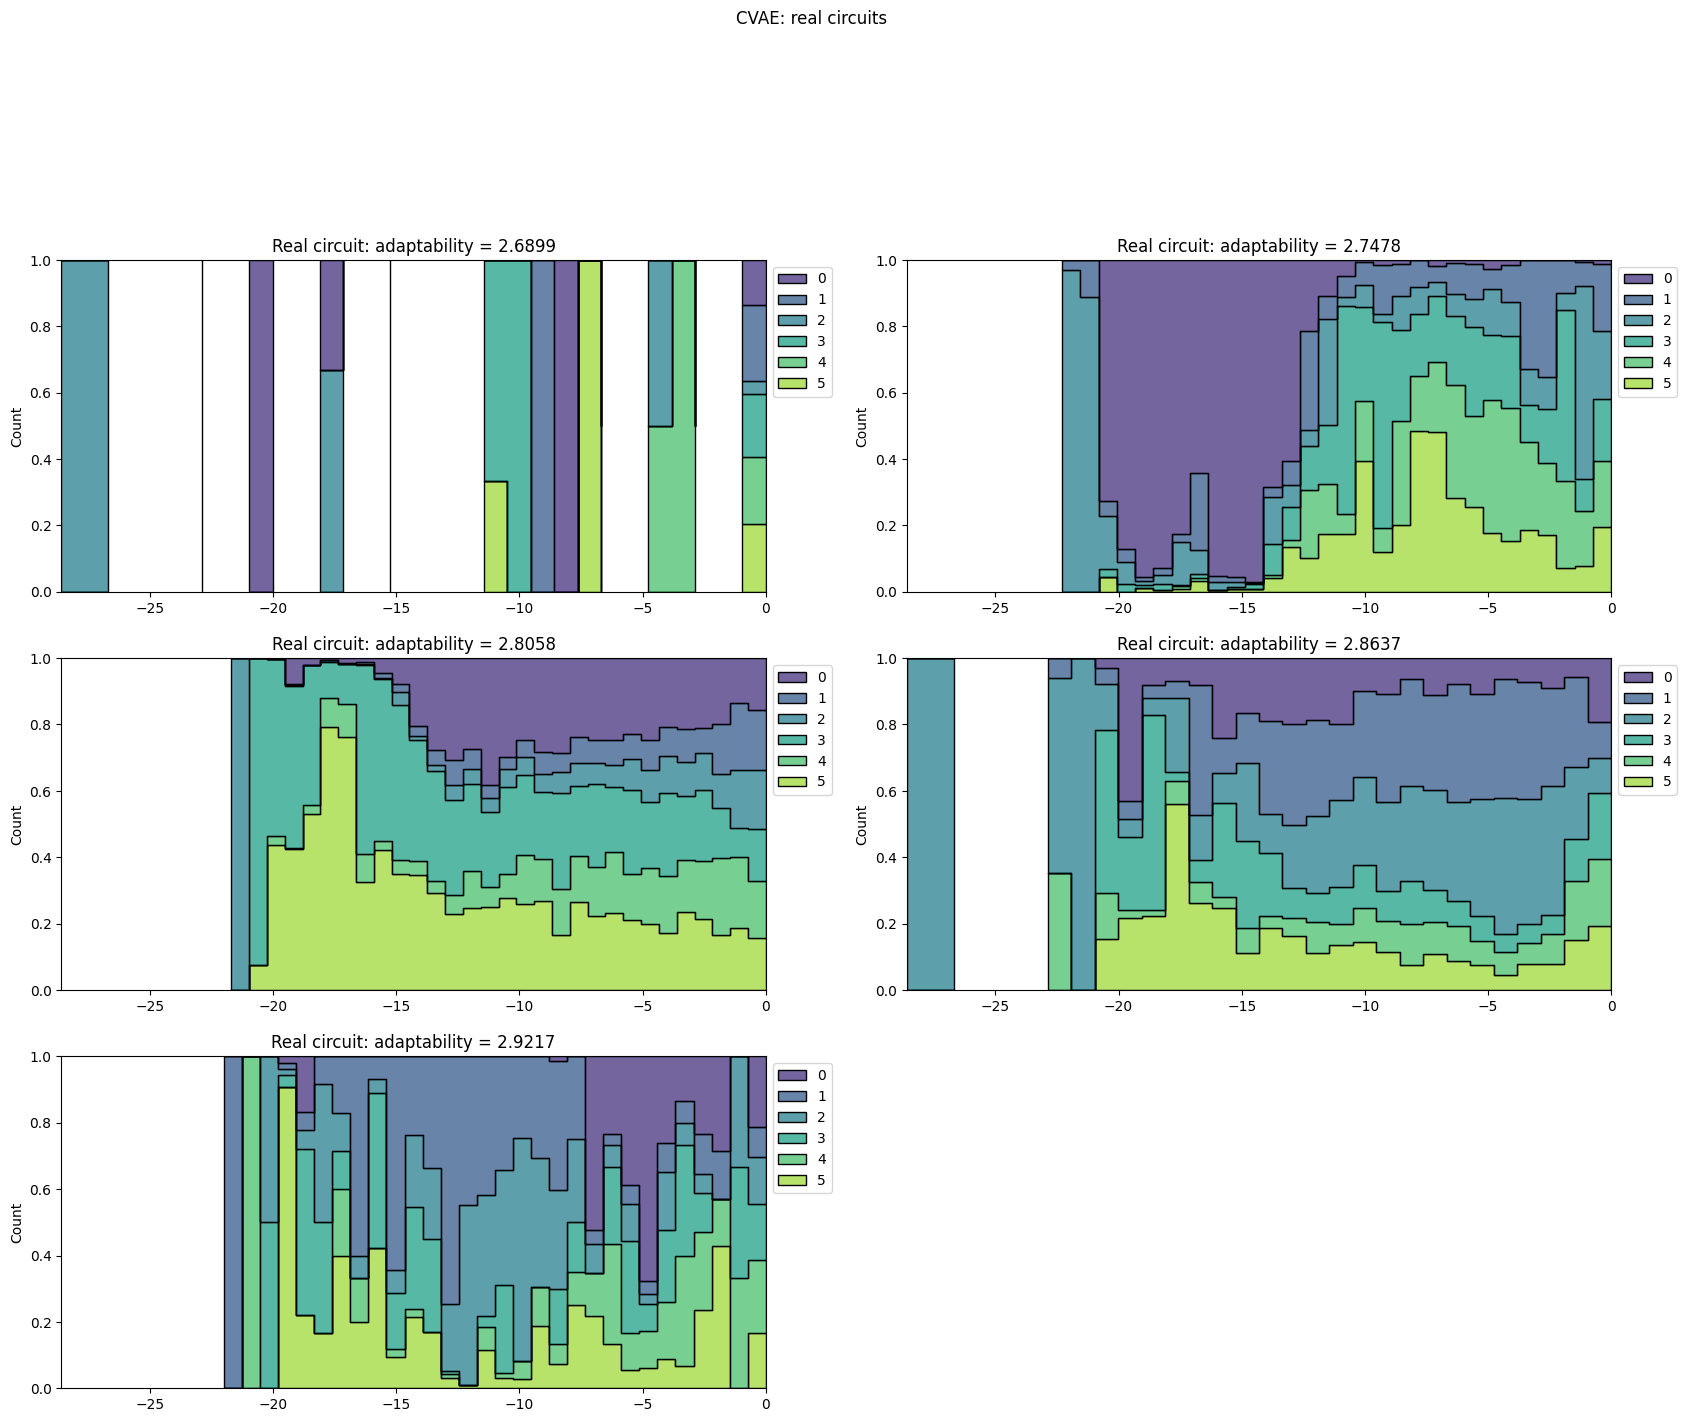

In [44]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
widest_lim = [0, 0]
for i, edge in enumerate(sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique())):
    cat = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge]
    cat = cat[X_COLS].to_numpy()
    
    ax = plt.subplot(5, 2, i+1)
    # g = sns.scatterplot(cat[:show_max])
    g = sns.histplot(cat, element='step', bins=30, palette='viridis', multiple='fill')
    plt.title(f'Real circuit: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
    widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
    g.set_xlim(widest_lim)

plt.suptitle(f'CVAE: real circuits')

### Combined

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real')

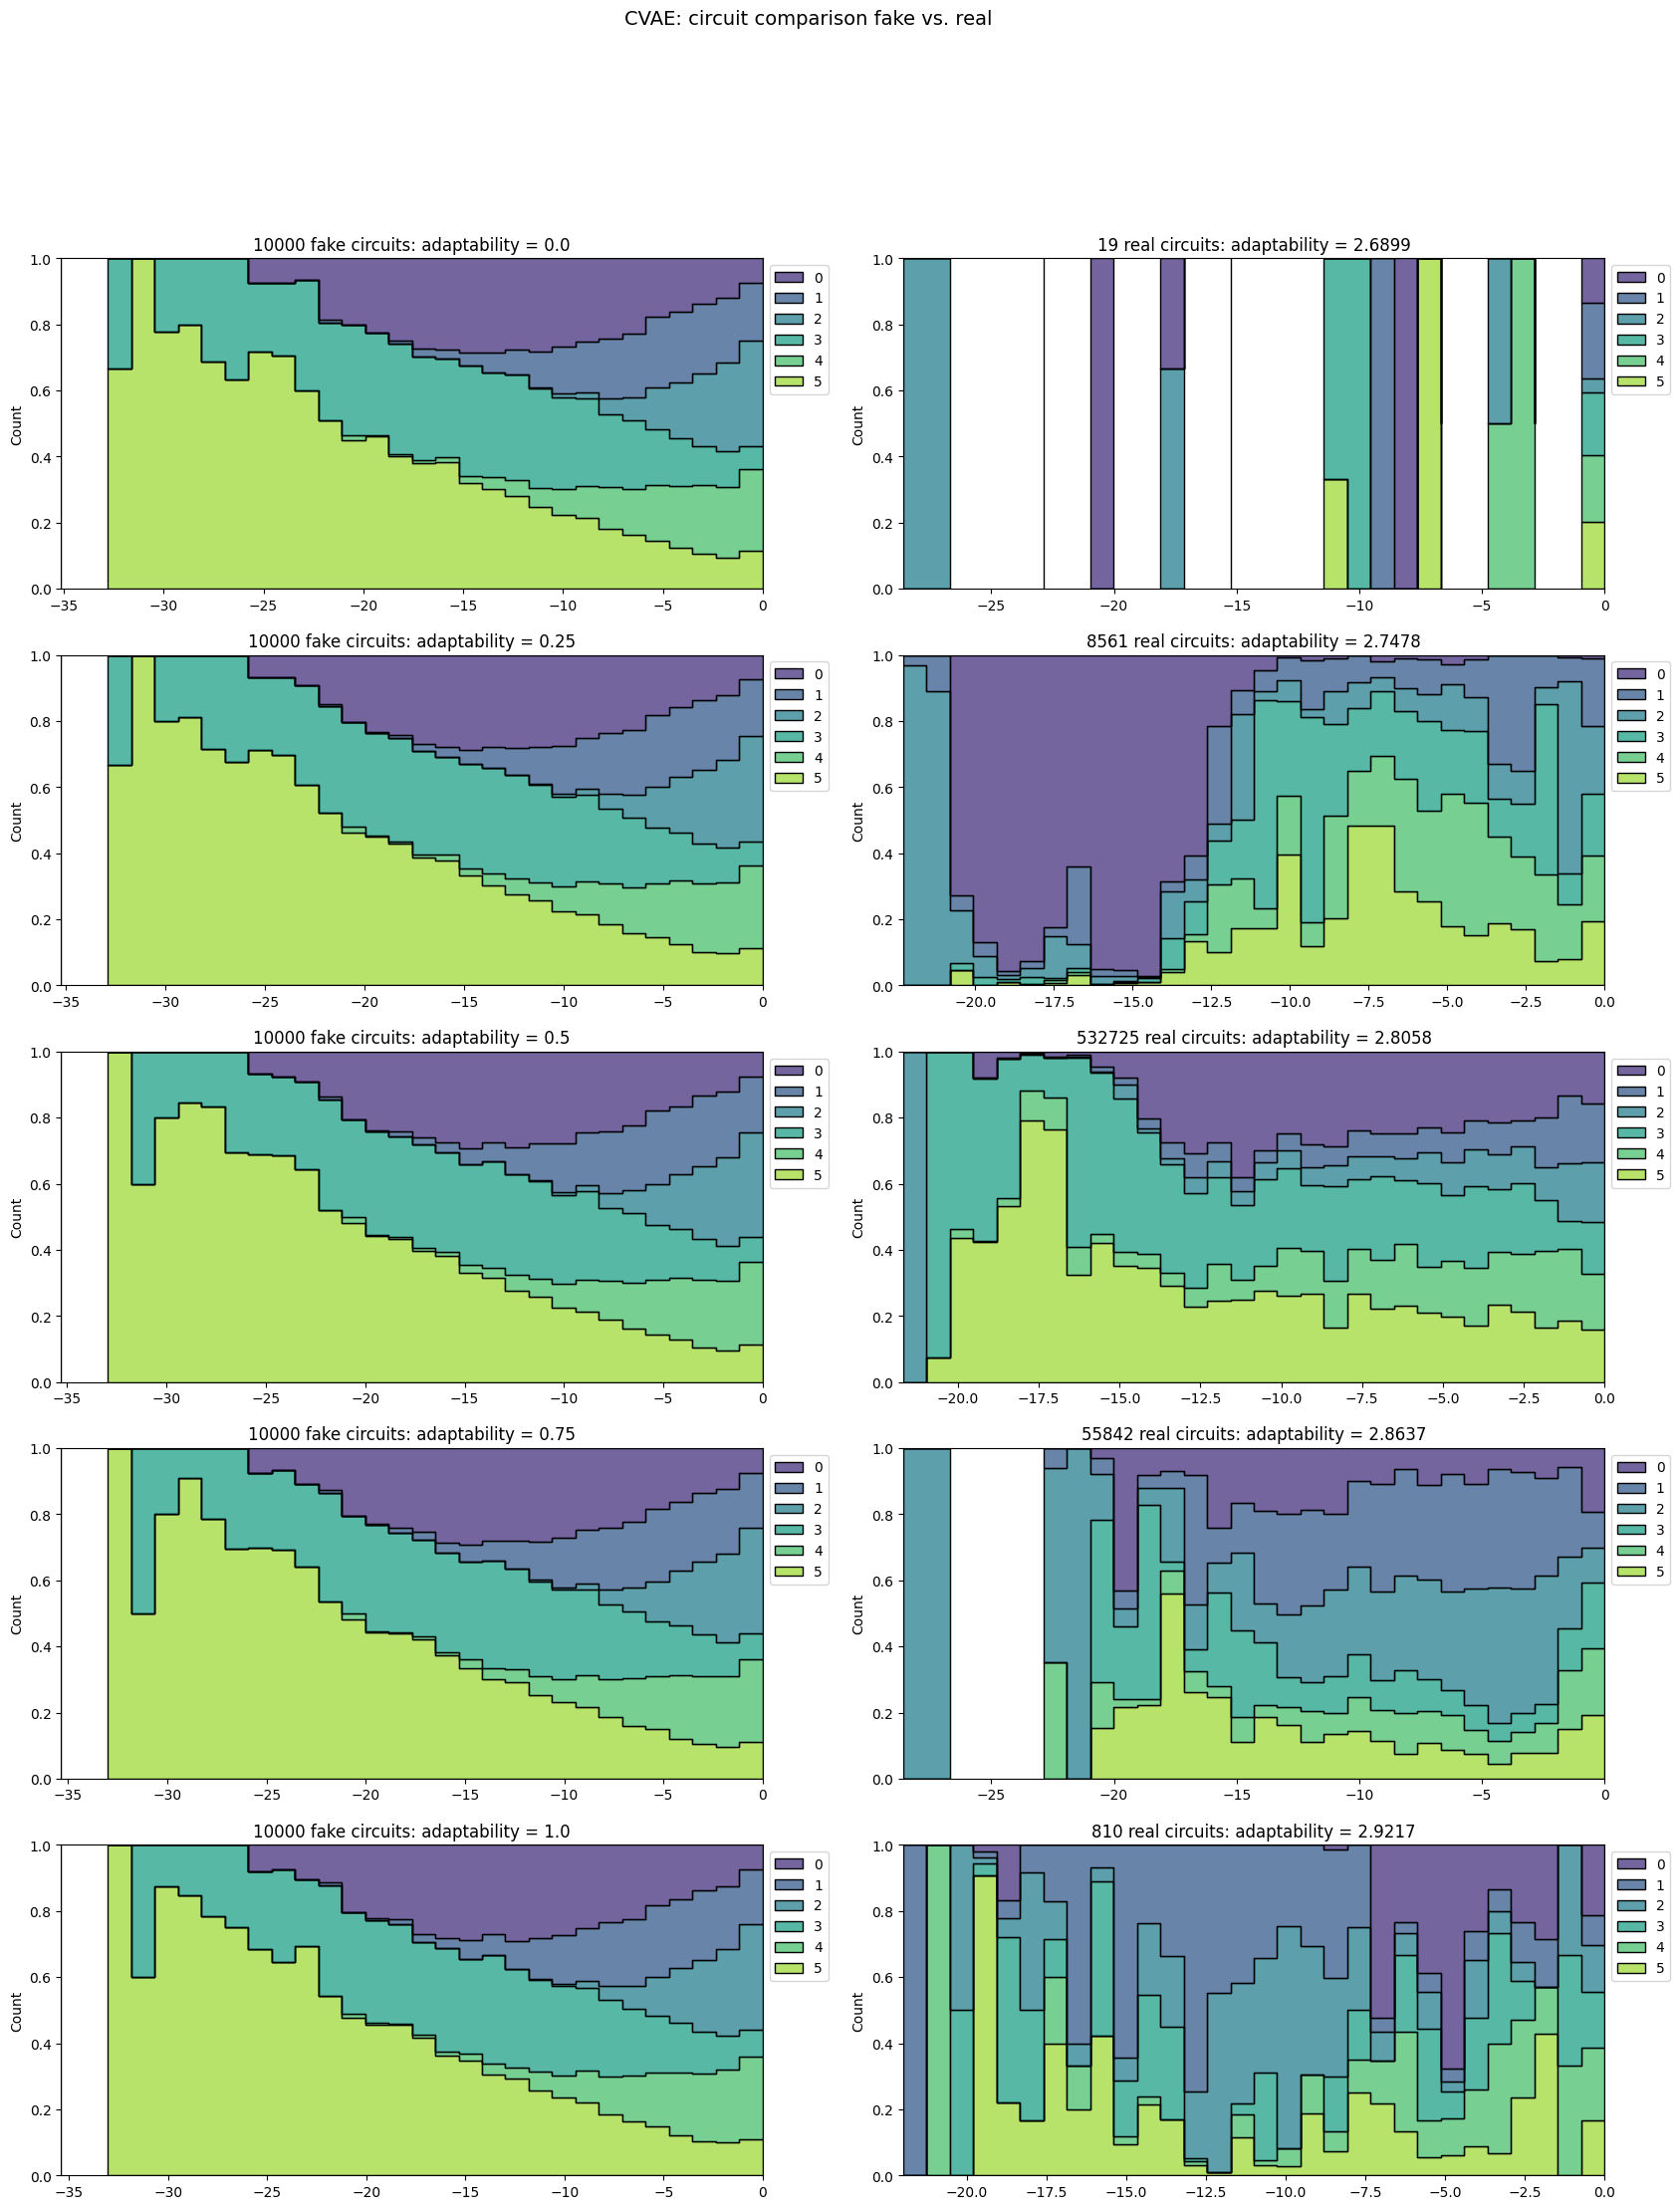

In [45]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique()))):
    widest_lim = [0, 0]
    real = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge][X_COLS].to_numpy()
    
    ax = plt.subplot(5, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='fill')
    plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sorted(np.unique(sampled_cond))[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(5, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='viridis', multiple='fill')
    plt.title(f'{len(real)} real circuits: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_lim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0], widest_lim[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1], widest_lim[1]])]
    # g1.set_xlim(widest_lim)
    # g2.set_xlim(widest_lim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real', fontsize=14)

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real')

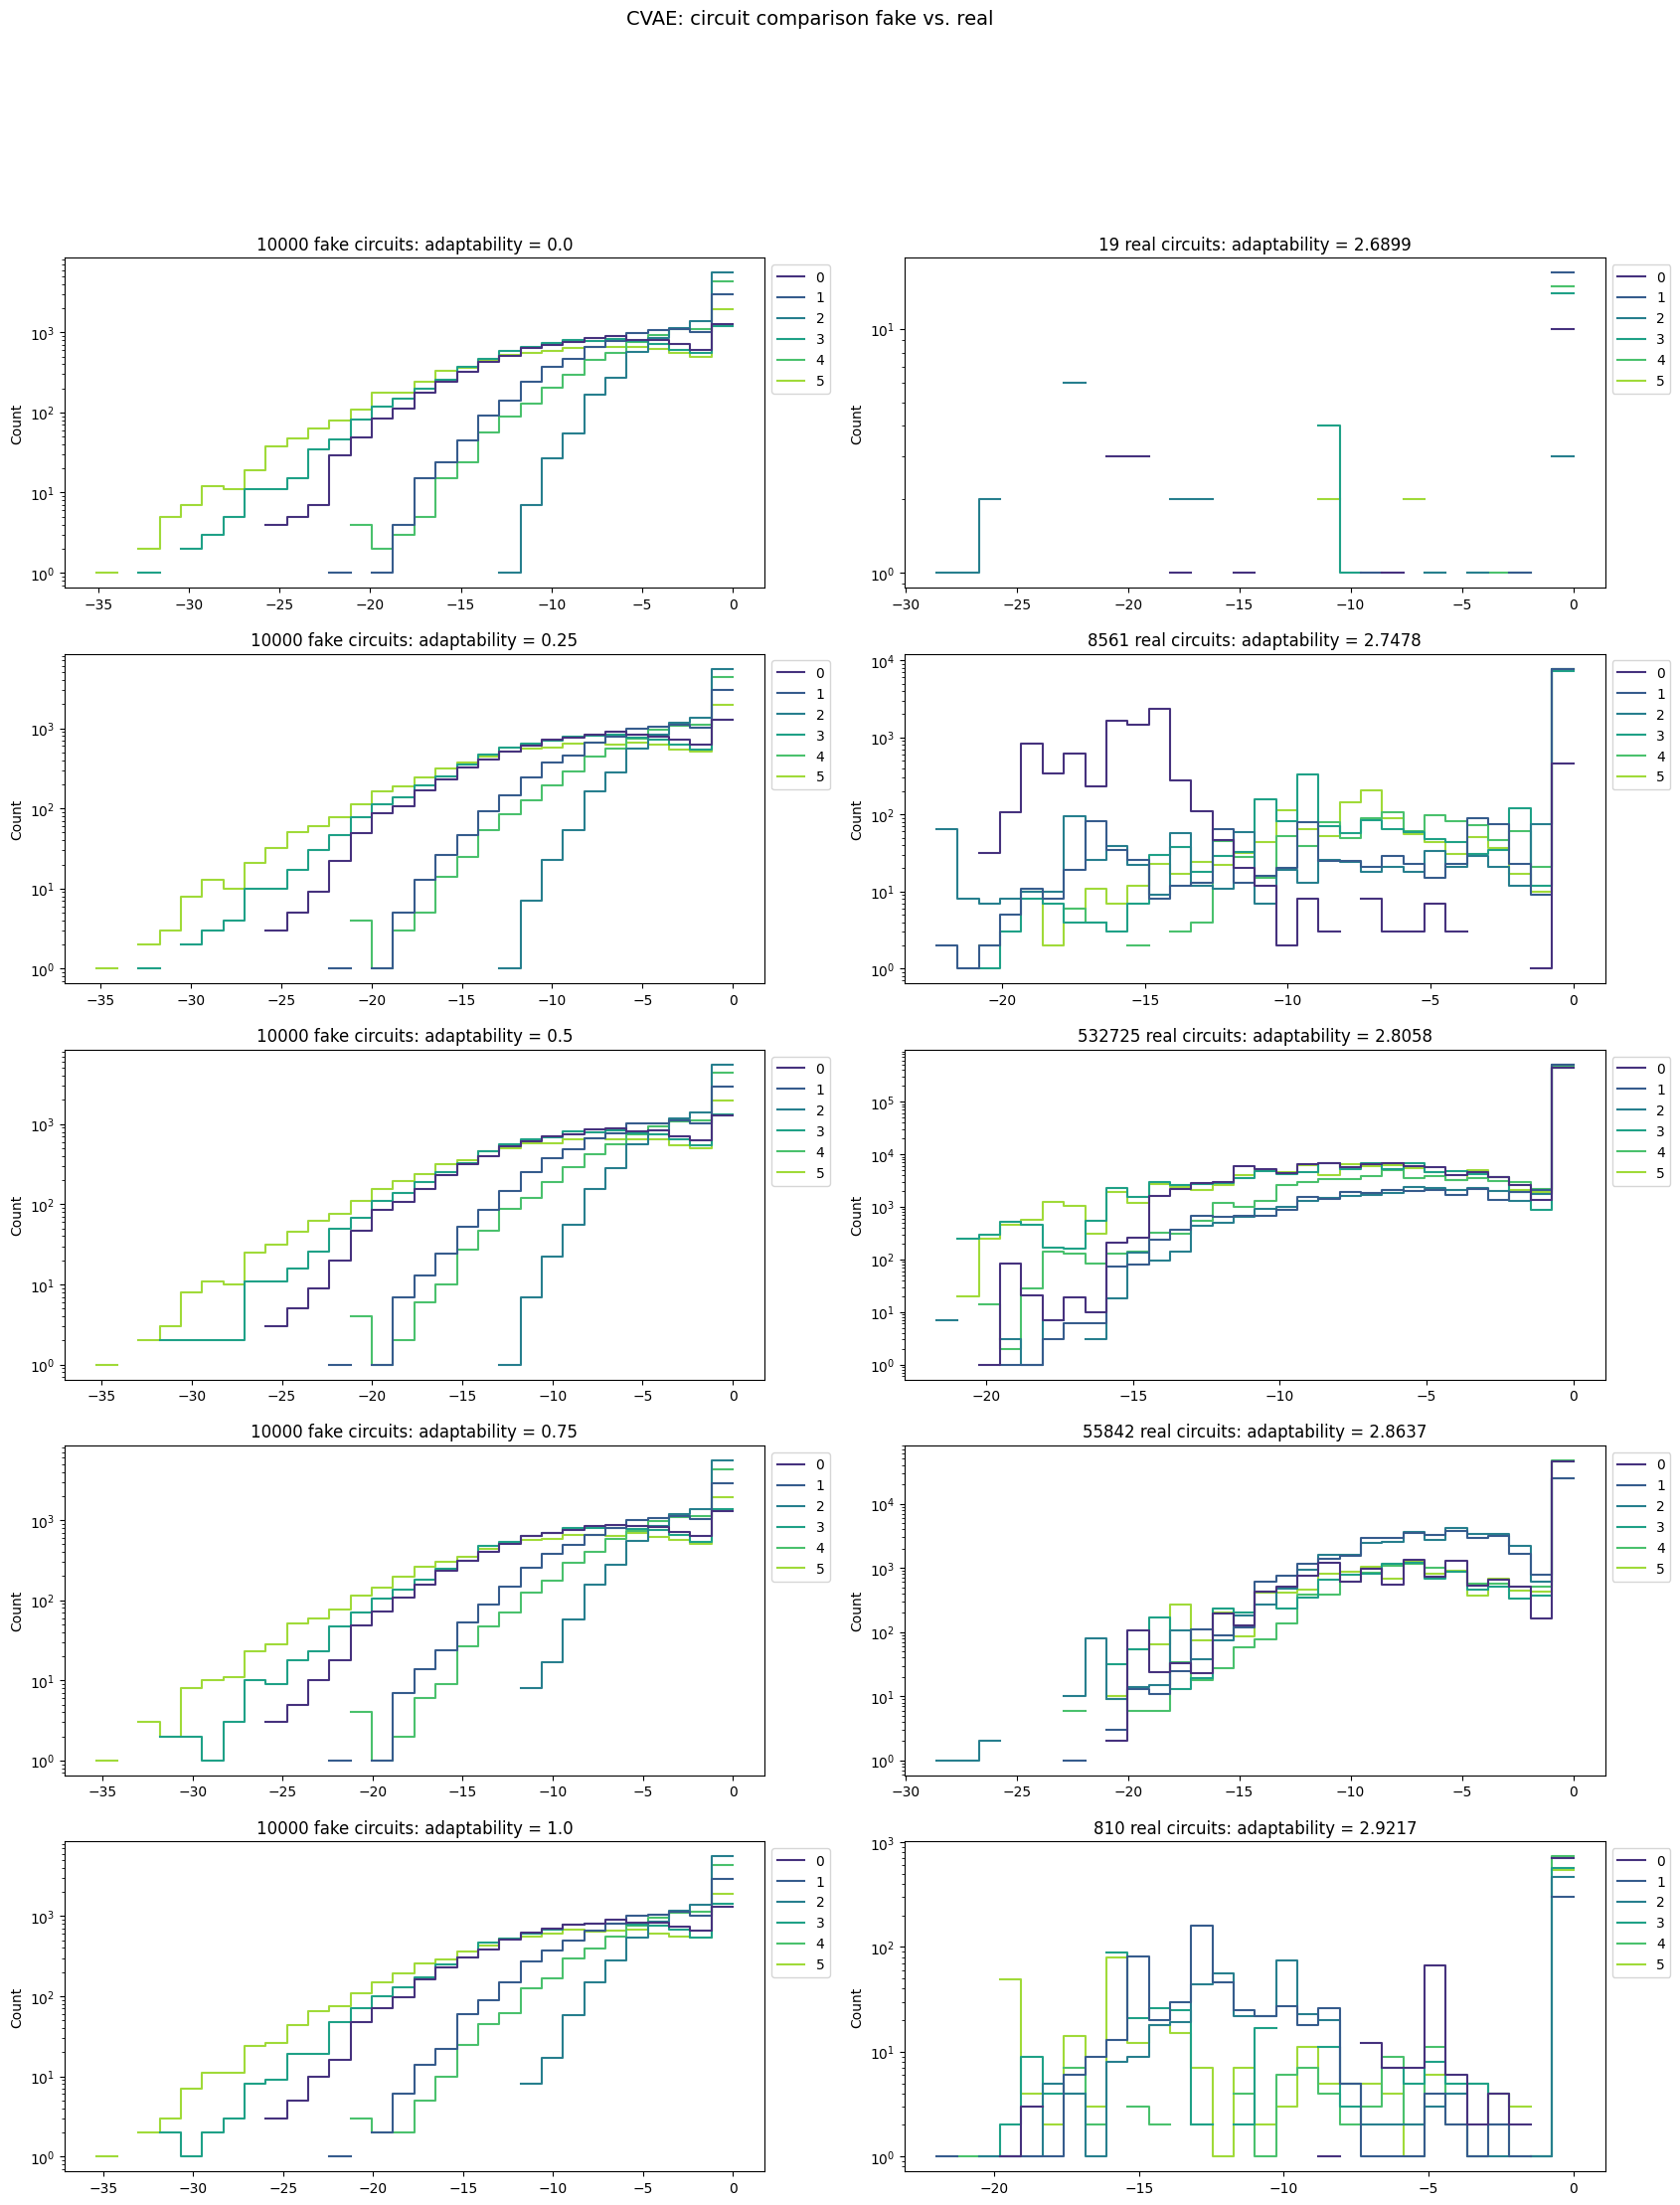

In [46]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique()))):
    real = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge][X_COLS].to_numpy()
    
    ax = plt.subplot(5, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='layer', fill=False, log_scale=[False, True])
    plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sorted(np.unique(sampled_cond))[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(5, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='viridis', multiple='layer', fill=False, log_scale=[False, True])
    plt.title(f'{len(real)} real circuits: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_xlim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1]])]
    widest_ylim = [np.min([g1.get_ylim()[0], g2.get_ylim()[0]]), np.max([g1.get_ylim()[1], g2.get_ylim()[1]])]
    # g1.set_xlim(widest_xlim)
    # g2.set_ylim(widest_ylim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real', fontsize=14)